## 다이나믹 프로그래밍

다이나믹 프로그래밍은 model-based 접근법으로, 환경의 전이 확률과 보상을 알고 있을 때 사용됩니다. 이번 코드에서는 DP 기법의 가치 이터레이션 (Value Iteration), 정책 이터레이션 (Policy Iteration)을 활용해 최적 정책을 찾습니다.

다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
GridWorld는 격자 기반 환경으로, 에이전트가 상, 하, 좌, 우로 이동하며 목표 지점에 도달해야 합니다.

```py
start_point = (0,0) # 시작점
end_point = (4,4) # 목표 지점
gridworld_size = (5,5) # 5x5 크기의 격자
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [ ]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [ ]:
class CustomGridWorld(GridWorldEnvironment):
    def render(self):
        # 기본 상태 초기화
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".")

        # trace(X), start point(S), end point(G), last_point(A)
        last_point = self.traces[-1] if self.traces else self.start_point
        traces = list(set(self.traces))

        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # 출력
        print("== GridWorld ==")
        for i in range(self.height):
            for j in range(self.width):
                print(self.grid_world[i][j], end=" ")
            print()
        print("===============")


# 01. 정책 이터레이션
정책 이터레이션은 정책 평가와 정책 개선을 번갈아 수행하며 최적 정책을 찾아가는 방법입니다.

- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

1. get_policy : 현재 상태에서의 정책 반환
2. get_value	: 현재 상태의 가치 반환
3. get_action : 현재 정책에 따라 행동 선택
4. policy_evaluation : 정책을 기준으로 가치 함수 업데이트
5. policy_improvement : 가치 함수를 이용해 최적 정책을 찾음

In [ ]:
class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist() # Appendix 1

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    # 현재 상태에서의 정책 반환
    def get_policy(self, state):
         return self.policy_table[state[0]][state[1]]

    # 현재 상태의 가치 반환
    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

    # 현재 정책에 따라 행동 선택
    def get_action(self,state):
        policy = self.get_policy(state)
        policy = np.array(policy)
        return np.random.choice(self.action_space, 1, p=policy)[0]

    # 정책을 기준으로 가치 함수 업데이트
    def policy_evaluation(self):
          # 다음 가치함수 초기화
        next_value_table = [[0.00] * self.env.width
                           for _ in range(self.env.height)]

        # 모든 상태에 대해서 벨만 기대방정식을 계산
        for state in self.env.total_states:
            value = 0.0
            # 마침 상태의 가치 함수 = 0
            if state == self.env.end_point:
                next_value_table[state[0]][state[1]] = value
                continue

            # 벨만 기대 방정식
            for action_idx, action in enumerate(self.env.action_space):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value += (self.get_policy(state)[action_idx] *
                          (reward + self.gamma * next_value))

            next_value_table[state[0]][state[1]] = value

        self.value_table = next_value_table

    def policy_improvement(self):
      import copy
      policy_stable = True  # 정책이 바뀌었는지 여부를 추적
      next_policy = copy.deepcopy(self.policy_table)

      for state in self.env.total_states:
        if state == self.env.end_point:
            continue

        value_list = []

        # 모든 행동에 대해 Q값 계산
        for action_idx, action in enumerate(self.env.action_space):
            next_state = self.env.state_after_action(state, action_idx)
            reward = self.env.get_reward(state, action_idx)
            next_value = self.get_value(next_state)
            value = reward + self.gamma * next_value
            value_list.append(value)

        # 최대 Q값을 가지는 행동들 선택
        max_idx_list = np.argwhere(value_list == np.amax(value_list)).flatten().tolist()
        prob = 1 / len(max_idx_list)
        new_policy = [prob if i in max_idx_list else 0.0 for i in range(self.num_action)]

        # 이전 정책과 비교 → 다르면 아직 수렴 안 된 것
        if new_policy != self.policy_table[state[0]][state[1]]:
            policy_stable = False

        # 정책 업데이트
        next_policy[state[0]][state[1]] = new_policy

      self.policy_table = next_policy
      return policy_stable  # 꼭 반환해야 while 루프에서 수렴 여부 확인 가능


* 변수 변경
* action은 숫자 인덱스 -> action_idx
* 새 policy를 만드는 건 deepcopy


```
import copy
next_policy = copy.deepcopy(self.policy_table)

```



❗정책 수렴 안 함.....


```
 # 가치 함수를 이용해 최적 정책을 찾음
    def policy_improvement(self):
        import copy
        next_policy = copy.deepcopy(self.policy_table)

        for state in self.env.total_states:
            if state == self.env.end_point:
                continue

            value_list = []
            # 반환할 정책 초기화
            result = [0.0, 0.0, 0.0, 0.0]

            # 모든 행동에 대해서 [보상 + (할인율 * 다음 상태 가치함수)] 계산
            for action_idx, action in enumerate(self.env.action_space):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value = reward + self.gamma * next_value
                value_list.append(value)

            # 받을 보상이 최대인 행동들에 대해 탐욕 정책 발전
            max_idx_list = np.argwhere(value_list == np.amax(value_list))
            max_idx_list = max_idx_list.flatten().tolist()
            prob = 1 / len(max_idx_list)

            for idx in max_idx_list:
                result[idx] = prob

            next_policy[state[0]][state[1]] = result

        self.policy_table = next_policy
```

=> policy_improvement() 함수가 정책이 바뀌었는지 확인하고 True/False 반환하도록 수정

## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [ ]:
# 환경 초기화
start_point = (0, 0)
end_point = (4, 4)
grid_size = (5, 5)

# Custom 환경 사용하거나 기본 환경 사용 가능
env = GridWorldEnvironment(start_point, end_point, grid_size)

#
env.reward[4][4] = 1  # 목표 좌표 (4,4)에 보상 직접 설정

# 에이전트 생성
agent = PolicyIteration(env)

# 정책 반복 수행
iteration = 0
while True:
    print(f"Iteration {iteration + 1}")
    agent.policy_evaluation()              # 정책 평가
    policy_stable = agent.policy_improvement()  # 정책 개선

    if policy_stable:
        print("정책이 수렴했습니다.")
        break

    iteration += 1


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
정책이 수렴했습니다.


## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

1. value_table 시각화 (Heatmap)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

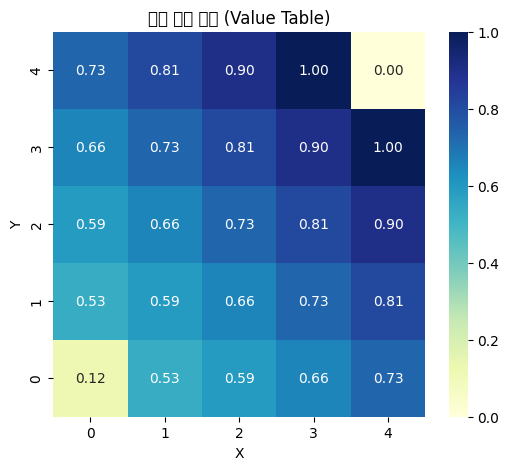

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_value_table(value_table):
    plt.figure(figsize=(6, 5))
    sns.heatmap(np.array(value_table), annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("상태 가치 함수 (Value Table)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()
    plt.show()

# 호출
plot_value_table(agent.value_table)

❗ (0,0)을 좌측 상단으로 보내고 싶었는데 실패.....

2. policy_table 시각화 (방향 화살표)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52293 (\N{HANGUL SYLLABLE CAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

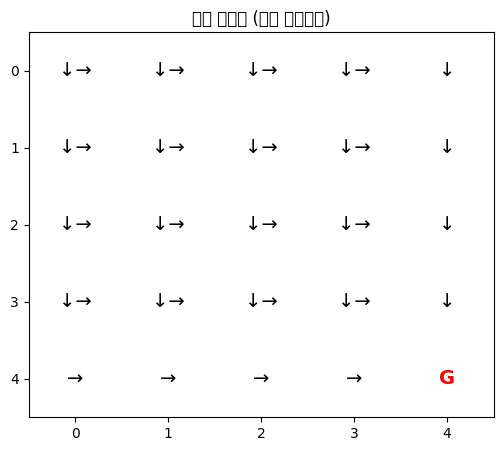

In [ ]:
def plot_policy_only(agent):
    height = agent.env.height
    width = agent.env.width

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_xlim(-0.5, width - 0.5)
    ax.set_ylim(-0.5, height - 0.5)
    ax.set_xticks(np.arange(width))
    ax.set_yticks(np.arange(height))
    ax.set_xticklabels(np.arange(width))
    ax.set_yticklabels(np.arange(height))
    ax.set_title("정책 시각화 (방향 화살표만)")

    arrow_dict = {
        0: '↑',
        1: '↓',
        2: '←',
        3: '→'
    }

    for i in range(height):
        for j in range(width):
            state = (i, j)
            if state == agent.env.end_point:
                ax.text(j, i, "G", ha='center', va='center', fontsize=14, fontweight='bold', color='red')
                continue

            try:
                # PolicyIteration이면 get_policy 사용
                policy = agent.get_policy(state)
                if policy:
                    best_action = np.argmax(policy)
                else:
                    continue
            except AttributeError:
                # ValueIteration이면 get_action 사용
                 action_list = agent.get_action(state)

             # 여러 방향이 있을 경우 화살표 문자열로 합쳐서 출력
            arrows = ''.join([arrow_dict[a] for a in action_list])
            ax.text(j, i, arrows, ha='center', va='center', color='black', fontsize=14)

    ax.invert_yaxis()
    plt.show()

plot_policy_only(agent)


# 02. 가치 이터레이션
가치 이터레이션은 정책 없이 직접 가치 함수를 최적화하는 방법입니다.
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.
1. value_iteration : 벨만 최적 방정식을 이용해 가치 함수를 반복적으로 업데이트
2. get_value : 현재 상태의 가치를 반환
3. get_action : 현재 가치 함수 기준으로 최적 행동 선택

In [ ]:
class ValueIteration:
    def __init__(self, env):

        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # 할인율

    def value_iteration(self, threshold=1e-4):
        while True:
          delta = 0
          next_value_table = [[0.0 for _ in range(self.env.width)] for _ in range(self.env.height)]

          for state in self.env.total_states:
              if state == self.env.end_point:
                continue

              value_list = []
              for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value_list.append(reward + self.gamma * next_value)

              max_value = max(value_list)
              delta = max(delta, abs(self.get_value(state) - max_value))
              next_value_table[state[0]][state[1]] = max_value

          self.value_table = next_value_table

          if delta < threshold:
            break


    def get_action(self, state):
        if state == self.env.end_point:
            return []

        # 모든 행동에 대해 큐함수 (보상 + (감가율 * 다음 상태 가치함수))를 계산
        value_list = []
        for action_idx in range(self.env.num_actions):
            next_state = self.env.state_after_action(state, action_idx)
            reward = self.env.get_reward(state, action_idx)
            next_value = self.get_value(next_state)
            value = (reward + self.gamma * next_value)
            value_list.append(value)

        # 최대 큐 함수를 가진 행동(복수일 경우 여러 개)을 반환
        max_idx_list = np.argwhere(value_list == np.amax(value_list))
        action_list = max_idx_list.flatten().tolist()
        return action_list

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]


* 변수 변경
* action은 숫자 인덱스 -> action_idx
* 수렴 조건 없음 → 반복 루프


```
def value_iteration(self):
          # 다음 가치함수 초기화
        next_value_table = [[0.0] * self.env.width
                           for _ in range(self.env.height)]

        # 모든 상태에 대해서 벨만 최적방정식을 계산
        for state in self.env.total_states:
            # 마침 상태의 가치 함수 = 0
            if state == self.env.end_point:
                next_value_table[state[0]][state[1]] = 0.0
                continue

            # 벨만 최적 방정식
            value_list = []
            for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value_list.append((reward + self.gamma * next_value))

            # 최댓값을 다음 가치 함수로 대입
            next_value_table[state[0]][state[1]] = max(value_list)

        self.value_table = next_value_table
```



## 가치 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [ ]:
# 환경 생성
start_point = (0, 0)
end_point = (4, 4)
grid_size = (5, 5)

env = GridWorldEnvironment(start_point, end_point, grid_size)
agent = ValueIteration(env)

# 가치 이터레이션 실행 (수렴할 때까지)
agent.value_iteration()

# 최종 가치 테이블 출력
for row in agent.value_table:
    print(["{0:0.2f}".format(v) for v in row])


['0.48', '0.53', '0.59', '0.66', '0.73']
['0.53', '0.59', '0.66', '0.73', '0.81']
['0.59', '0.66', '0.73', '0.81', '0.90']
['0.66', '0.73', '0.81', '0.90', '1.00']
['0.73', '0.81', '0.90', '1.00', '0.00']


## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

1. value_table 시각화 (Heatmap)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

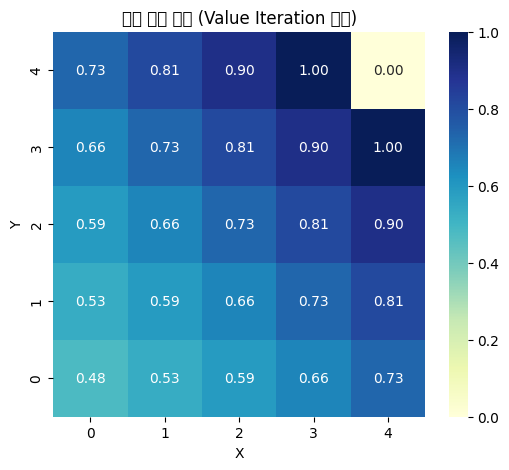

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_value_table(value_table):
    value_array = np.array(value_table)
    flipped = np.flipud(value_array)
    height = value_array.shape[0]

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        flipped,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        cbar=True
    )
    plt.title("상태 가치 함수 (Value Iteration 기반)")
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.yticks(
        ticks=np.arange(height) + 0.5,
        labels=list(reversed(range(height)))
    )

    plt.show()


plot_value_table(agent.value_table)


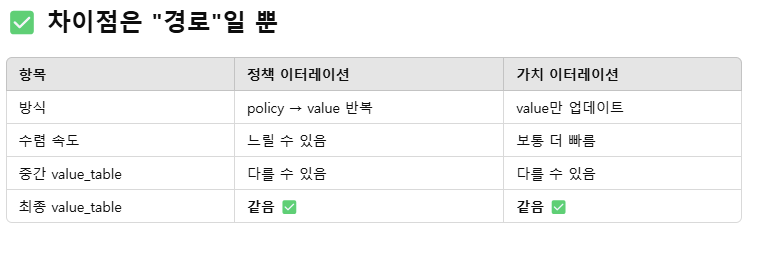

2. policy_table 시각화 (방향 화살표)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52293 (\N{HANGUL SYLLABLE CAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


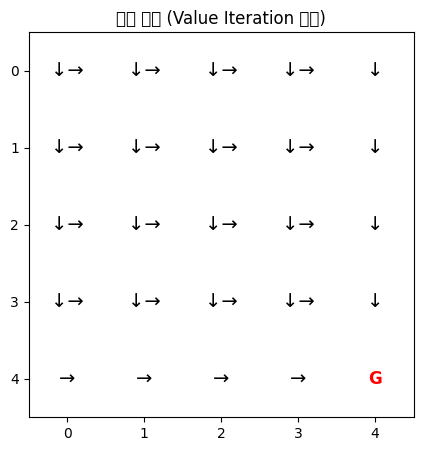

In [ ]:
def plot_policy_heatmap(agent):
    height = len(agent.value_table)
    width = len(agent.value_table[0])

    fig, ax = plt.subplots(figsize=(6, 5))
    heatmap = np.zeros((height, width))
    ax.imshow(heatmap, cmap="Greys", vmin=0, vmax=1)

    arrow_dict = {
        0: '↑',
        1: '↓',
        2: '←',
        3: '→'
    }

    for i in range(height):
        for j in range(width):
            state = (i, j)
            if state == agent.env.end_point:
                ax.text(j, i, 'G', ha='center', va='center', color='red', fontsize=12, fontweight='bold')
                continue

            action_list = agent.get_action(state)
            if not action_list:
                continue

            # 여러 방향이 있을 경우 화살표 문자열로 합쳐서 출력
            arrows = ''.join([arrow_dict[a] for a in action_list])
            ax.text(j, i, arrows, ha='center', va='center', color='black', fontsize=14)

    ax.set_xticks(np.arange(width))
    ax.set_yticks(np.arange(height))
    ax.set_xticklabels(np.arange(width))
    ax.set_yticklabels(np.arange(height))

    ax.set_title("정책 방향 (Value Iteration 기반)")
    plt.grid(False)
    plt.show()

plot_policy_heatmap(agent)


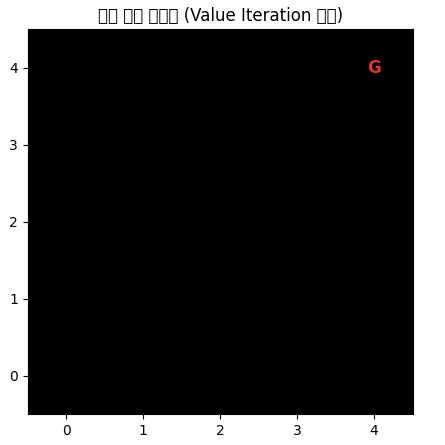

In [ ]:
for i in range(5):
    for j in range(5):
        print((i, j), agent.get_action((i, j)))


(0, 0) [1, 3]
(0, 1) [1, 3]
(0, 2) [1, 3]
(0, 3) [1, 3]
(0, 4) [1]
(1, 0) [1, 3]
(1, 1) [1, 3]
(1, 2) [1, 3]
(1, 3) [1, 3]
(1, 4) [1]
(2, 0) [1, 3]
(2, 1) [1, 3]
(2, 2) [1, 3]
(2, 3) [1, 3]
(2, 4) [1]
(3, 0) [1, 3]
(3, 1) [1, 3]
(3, 2) [1, 3]
(3, 3) [1, 3]
(3, 4) [1]
(4, 0) [3]
(4, 1) [3]
(4, 2) [3]
(4, 3) [3]
(4, 4) []


In [ ]:
for i in range(5):
    for j in range(5):
        print(f"state=({i},{j}) -> action(s): {agent.get_action((i,j))}")


state=(0,0) -> action(s): [1, 3]
state=(0,1) -> action(s): [1, 3]
state=(0,2) -> action(s): [1, 3]
state=(0,3) -> action(s): [1, 3]
state=(0,4) -> action(s): [1]
state=(1,0) -> action(s): [1, 3]
state=(1,1) -> action(s): [1, 3]
state=(1,2) -> action(s): [1, 3]
state=(1,3) -> action(s): [1, 3]
state=(1,4) -> action(s): [1]
state=(2,0) -> action(s): [1, 3]
state=(2,1) -> action(s): [1, 3]
state=(2,2) -> action(s): [1, 3]
state=(2,3) -> action(s): [1, 3]
state=(2,4) -> action(s): [1]
state=(3,0) -> action(s): [1, 3]
state=(3,1) -> action(s): [1, 3]
state=(3,2) -> action(s): [1, 3]
state=(3,3) -> action(s): [1, 3]
state=(3,4) -> action(s): [1]
state=(4,0) -> action(s): [3]
state=(4,1) -> action(s): [3]
state=(4,2) -> action(s): [3]
state=(4,3) -> action(s): [3]
state=(4,4) -> action(s): []


-> 시각화 코드가 여러방향을 못 보여줌
-> 여러 개의 최적 행동이 있을 때도 "↓→" 식으로 한 셀에 다 표시되도록 수정

=> best_action -> action_list

```
arrows = ''.join([arrow_dict[a] for a in action_list])

```

